In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from prophet import Prophet

## 1. Data Loading and Preparation
def load_and_prepare_data(filepath):
    # Load data
    df = pd.read_csv(filepath, parse_dates=['TANGGAL'], dayfirst=True)

    # Handle missing values
    df.replace(['-', '8888'], np.nan, inplace=True)

    # Convert numeric columns
    numeric_cols = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS', 'FF_X', 'DDD_X', 'FF_AVG']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

    # Create date features
    df['year'] = df['TANGGAL'].dt.year
    df['month'] = df['TANGGAL'].dt.month
    df['day_of_year'] = df['TANGGAL'].dt.dayofyear

    # Aggregate to monthly data
    monthly_df = df.groupby(['year', 'month']).agg({
        'TAVG': 'mean',
        'TN': 'mean',
        'TX': 'mean',
        'RH_AVG': 'mean',
        'RR': 'sum',
        'SS': 'mean'
    }).reset_index()

    # Create datetime index
    monthly_df['date'] = pd.to_datetime(monthly_df[['year', 'month']].assign(day=1))
    monthly_df.set_index('date', inplace=True)

    return monthly_df

In [18]:
## 2. Feature Engineering with Trends and Seasonality
def add_temporal_features(df):
    # Time index
    df['time_index'] = np.arange(len(df))

    # Polynomial time features
    df['time_index_squared'] = df['time_index']**2

    # Cyclical month features
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Lag features
    for lag in [1, 12]:  # 1 month, 1 year lags
        df[f'TAVG_lag_{lag}'] = df['TAVG'].shift(lag)

    # Rolling statistics
    df['TAVG_rolling_12_mean'] = df['TAVG'].rolling(window=12).mean()

    return df.dropna()

In [19]:
## 3. Correlation Analysis
def plot_correlation_matrix(df):
    # Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                annot_kws={"size": 10}, linewidths=0.5)
    plt.title('Feature Correlation Matrix', pad=20, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print top correlations with TAVG
    print("\nTop Correlations with TAVG:")
    print(corr_matrix['TAVG'].sort_values(ascending=False).head(10))

In [20]:
## 4. Prophet Forecasting Function
def run_prophet_forecast(df, periods=60):
    prophet_df = pd.DataFrame({
        'ds': df.index,
        'y': df['TAVG']
    })

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    return forecast

In [36]:

## 5. Model Training and Evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'XGBoost': XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
        'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    }

    # Train and evaluate
    metrics = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        metrics[name] = {
            'MSE': mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }

    return metrics, models, scaler

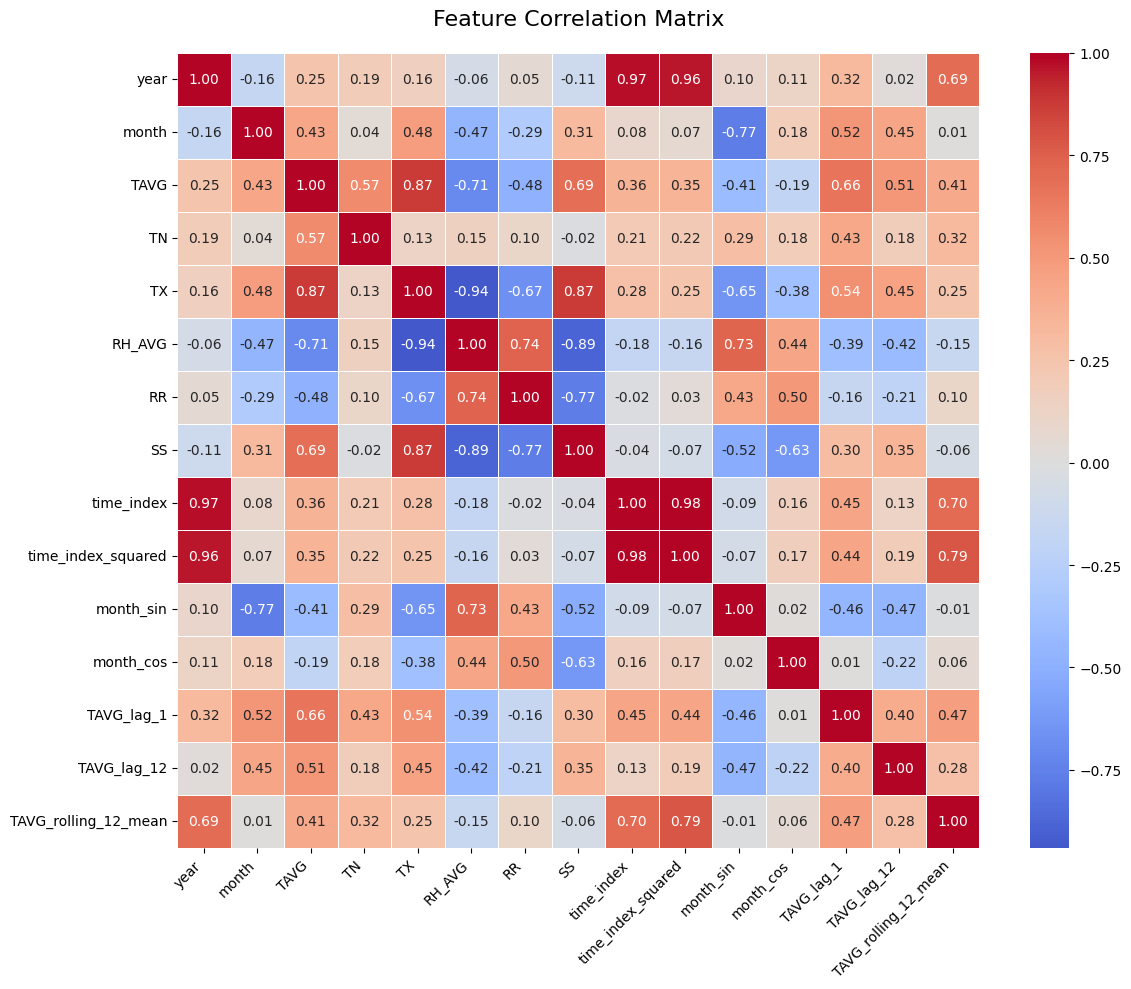


Top Correlations with TAVG:
TAVG                    1.000000
TX                      0.872538
SS                      0.689108
TAVG_lag_1              0.660755
TN                      0.567767
TAVG_lag_12             0.512317
month                   0.433717
TAVG_rolling_12_mean    0.409342
time_index              0.361430
time_index_squared      0.354883
Name: TAVG, dtype: float64


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mgsamyh/oabadagi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mgsamyh/8745hu6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36708', 'data', 'file=/tmp/tmp_mgsamyh/oabadagi.json', 'init=/tmp/tmp_mgsamyh/8745hu6s.json', 'output', 'file=/tmp/tmp_mgsamyh/prophet_model4uiddqag/prophet_model-20250520230130.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:01:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Model Performance Metrics:
                    MSE       MAE        R2
XGBoost        0.148262  0.288195  0.814643
Random Forest  0.157167  0.287233  0.803510
SVR            0.638626  0.657966  0.201588


23:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


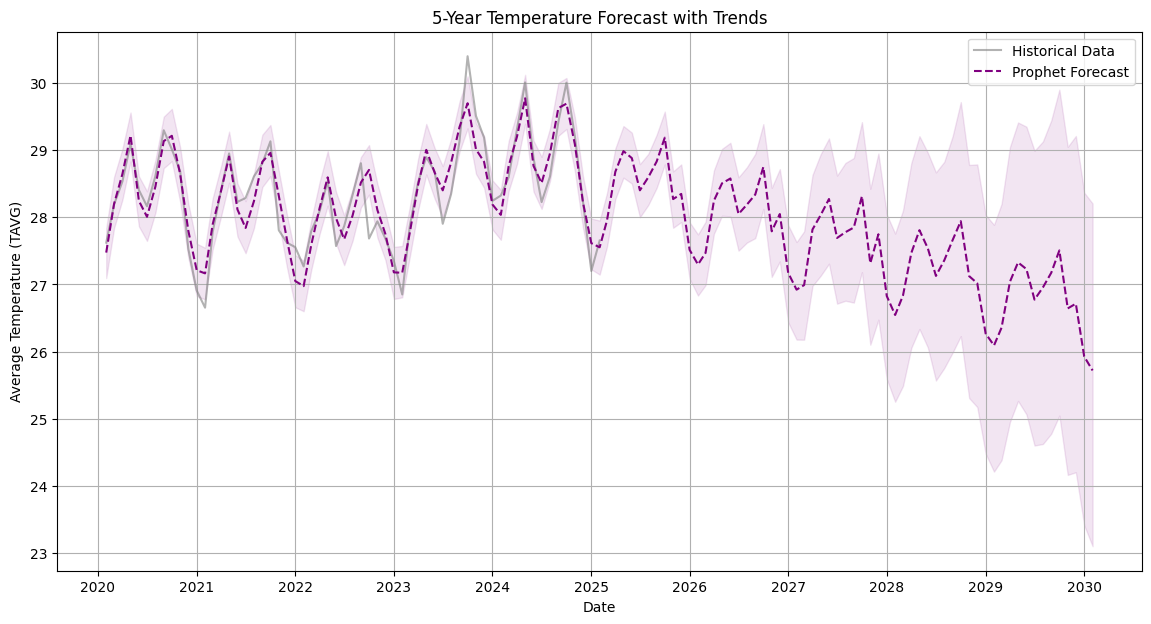

In [37]:
## 6. Main Execution
def main():
    # Load and prepare data
    filepath = 'data.csv'  # Change to your file path
    monthly_df = load_and_prepare_data(filepath)

    # Add temporal features
    feature_df = add_temporal_features(monthly_df)

    # Plot correlation matrix
    plot_correlation_matrix(feature_df)

    # Prepare features and target
    X = feature_df.drop(columns=['TAVG', 'year', 'month'])
    y = feature_df['TAVG']

    # Train-test split (last 20% for testing)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Train and evaluate models
    metrics, models, scaler = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    print("\nModel Performance Metrics:")
    print(pd.DataFrame(metrics).T)

    # Get Prophet forecast for comparison
    prophet_results = run_prophet_forecast(monthly_df)

    # Visualization
    plt.figure(figsize=(14, 7))

    # Plot historical data
    plt.plot(monthly_df.index, monthly_df['TAVG'], label='Historical Data', color='gray', alpha=0.6)

    # Plot Prophet forecast
    plt.plot(prophet_results['ds'], prophet_results['yhat'],
             label='Prophet Forecast', linestyle='--', color='purple')

    plt.fill_between(prophet_results['ds'],
                    prophet_results['yhat_lower'],
                    prophet_results['yhat_upper'],
                    color='purple', alpha=0.1)

    plt.title('5-Year Temperature Forecast with Trends')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (TAVG)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import time
from typing import Dict, Tuple, Any, Optional
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve, TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance


def plot_learning_curve(
    model: Any,
    X: np.ndarray,
    y: pd.Series,
    model_name: str,
    cv: Any = 5,
    train_sizes: np.ndarray = np.linspace(0.1, 1.0, 5),
    scoring: str = 'neg_mean_squared_error'
) -> None:
    """
    Enhanced learning curve visualization with time-series cross-validation support.

    Args:
        model: The machine learning model
        X: Features (numpy array)
        y: Target variable
        model_name: Name of the model (for title)
        cv: Cross-validation strategy (default: 5)
        train_sizes: Proportion of training data to use
        scoring: Scoring metric
    """
    # Use TimeSeriesSplit for time-series data
    cv_method = TimeSeriesSplit(n_splits=cv) if isinstance(cv, int) else cv

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=cv_method,
        train_sizes=train_sizes,
        scoring=scoring,
        n_jobs=-1,
        random_state=42
    )

    # Calculate statistics
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))
    train_scores_std = np.sqrt(-train_scores.std(axis=1))
    test_scores_std = np.sqrt(-test_scores.std(axis=1))

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training Score (RMSE)", linewidth=2)
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="CV Score (RMSE)", linewidth=2)

    # Add confidence bands
    ax.fill_between(train_sizes,
                   train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std,
                   alpha=0.1, color="r")
    ax.fill_between(train_sizes,
                   test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std,
                   alpha=0.1, color="g")

    # Customize plot
    ax.set_title(f"Learning Curve: {model_name}\n(Time Series Cross-Validation)",
                fontsize=14, pad=20)
    ax.set_xlabel("Training Examples", fontsize=12)
    ax.set_ylabel("RMSE", fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_xgboost_metrics(evals_result: Dict) -> None:
    """Plot XGBoost's training history metrics."""
    plt.figure(figsize=(12, 6))
    epochs = len(evals_result['validation_0']['rmse'])
    x_axis = range(0, epochs)

    plt.plot(x_axis, evals_result['validation_0']['rmse'],
             label='Train', linewidth=2)
    plt.plot(x_axis, evals_result['validation_1']['rmse'],
             label='Validation', linewidth=2)

    plt.title('XGBoost Training History', fontsize=14, pad=20)
    plt.xlabel('Boosting Rounds', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def train_and_evaluate_models(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    verbose: bool = True,
    plot_learning_curves: bool = True,
    time_series: bool = True
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Any], StandardScaler]:
    """
    Enhanced model training and evaluation with time-series support.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training target values
        y_test: Test target values
        verbose: Print training progress
        plot_learning_curves: Generate learning curves
        time_series: Whether data is time-series

    Returns:
        Tuple of (metrics, models, scaler)
    """
    # Input validation
    assert X_train.shape[0] == y_train.shape[0], "Shape mismatch between X_train and y_train"
    assert X_test.shape[0] == y_test.shape[0], "Shape mismatch between X_test and y_test"

    # Feature scaling
    if verbose:
        print("🔧 Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model configuration
    models = {
        'XGBoost': {
            'model': XGBRegressor(
                n_estimators=500,
                learning_rate=0.03,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1,
                early_stopping_rounds=20,
                eval_metric='rmse'
            ),
            'needs_dmatrix': False
        },
        'Random Forest': {
            'model': RandomForestRegressor(
                n_estimators=300,
                max_depth=None,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features='sqrt',
                bootstrap=True,
                oob_score=True,
                random_state=42,
                n_jobs=-1,
                warm_start=True
            ),
            'needs_dmatrix': False
        },
        'SVR': {
            'model': SVR(
                kernel='rbf',
                C=100,
                gamma='scale',
                epsilon=0.1,
                shrinking=True,
                tol=0.001,
                max_iter=10000
            ),
            'needs_dmatrix': False
        }
    }

    # Training and evaluation
    metrics = {}
    training_times = {}
    feature_importances = {}

    for name, config in models.items():
        model = config['model']
        needs_dmatrix = config['needs_dmatrix']

        if verbose:
            print(f"\n🚀 Training {name}...")

        start_time = time.time()

        try:
            # Special handling for XGBoost
            if name == 'XGBoost':
                model.fit(
                    X_train_scaled, y_train,
                    eval_set=[(X_train_scaled, y_train),
                             (X_test_scaled, y_test)],
                    verbose=verbose
                )

                # Store evaluation results
                evals_result = model.evals_result()

                if plot_learning_curves:
                    plot_xgboost_metrics(evals_result)

                # Get feature importance
                importance = model.feature_importances_
                feature_importances[name] = pd.Series(
                    importance,
                    index=X_train.columns
                ).sort_values(ascending=False)

            else:
                model.fit(X_train_scaled, y_train)

                if plot_learning_curves:
                    plot_learning_curve(
                        model,
                        X_train_scaled,
                        y_train,
                        name,
                        cv=TimeSeriesSplit(n_splits=5) if time_series else 5
                    )

                # Get feature importance if available
                if hasattr(model, 'feature_importances_'):
                    importance = model.feature_importances_
                    feature_importances[name] = pd.Series(
                        importance,
                        index=X_train.columns
                    ).sort_values(ascending=False)
                elif hasattr(model, 'coef_'):
                    importance = np.abs(model.coef_)
                    feature_importances[name] = pd.Series(
                        importance,
                        index=X_train.columns
                    ).sort_values(ascending=False)

            training_time = time.time() - start_time
            training_times[name] = training_time

            # Predictions
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            metrics[name] = {
                'MSE': mean_squared_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred),
                'Training Time (s)': training_time,
                'Avg Prediction': np.mean(y_pred),
                'Std Prediction': np.std(y_pred)
            }

            if verbose:
                print(f"✅ {name} training completed in {training_time:.2f} seconds")
                print(pd.DataFrame(metrics[name], index=[name]).T)

        except Exception as e:
            print(f"❌ Error training {name}: {str(e)}")
            metrics[name] = None

    # Print summary
    if verbose:
        print("\n📊 Model Performance Summary:")
        metrics_df = pd.DataFrame(metrics).T
        metrics_df = metrics_df.sort_values(by='RMSE')
        print(metrics_df)

        # Plot feature importance if available
        if feature_importances:
            print("\n🔍 Feature Importance:")
            for model_name, importance in feature_importances.items():
                plt.figure(figsize=(10, 6))
                importance.head(10).plot(kind='barh')
                plt.title(f'Top 10 Features - {model_name}')
                plt.xlabel('Importance Score')
                plt.tight_layout()
                plt.show()

    return metrics, {name: config['model'] for name, config in models.items()}, scaler

Loading and preparing data...

Adding temporal features...


<Figure size 1200x600 with 0 Axes>

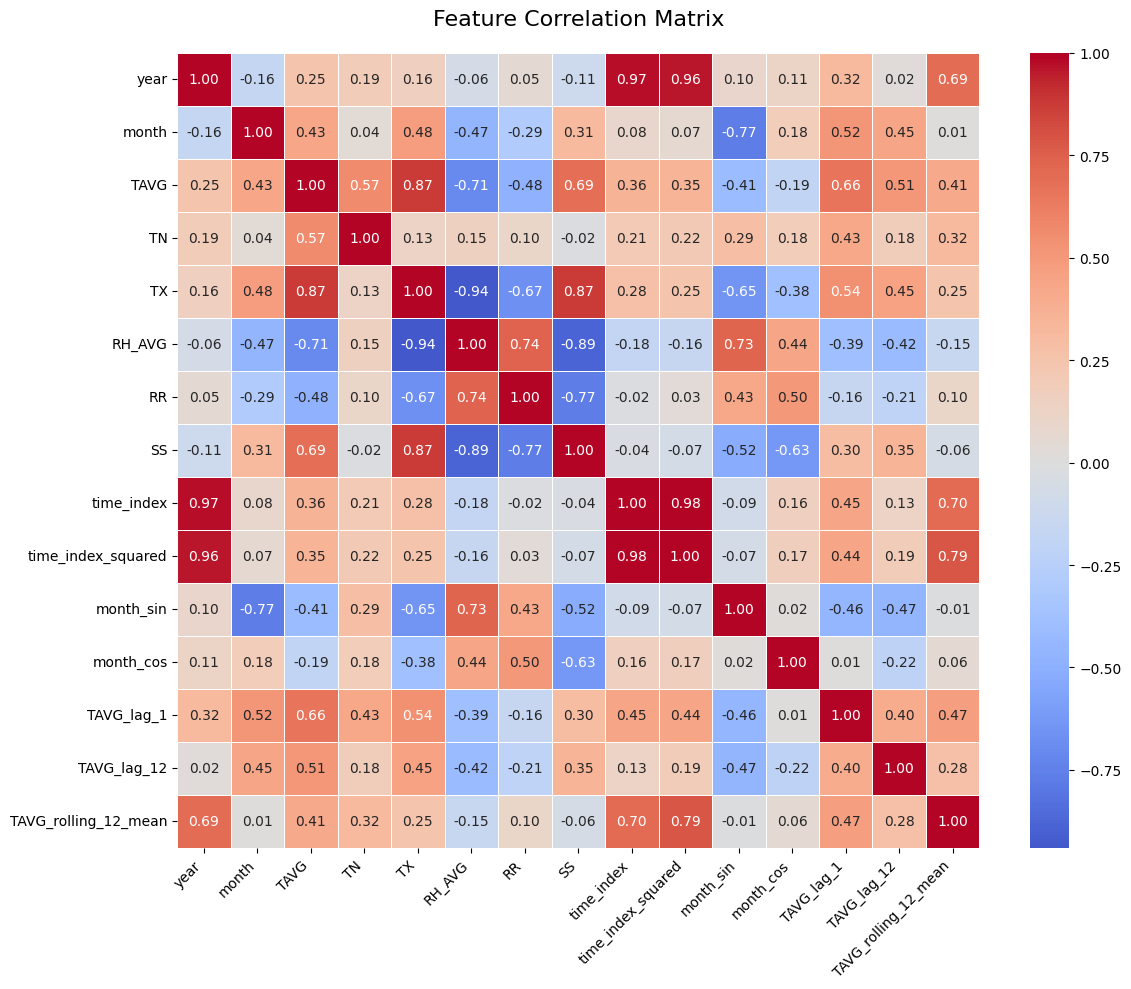


Top Correlations with TAVG:
TAVG                    1.000000
TX                      0.872538
SS                      0.689108
TAVG_lag_1              0.660755
TN                      0.567767
TAVG_lag_12             0.512317
month                   0.433717
TAVG_rolling_12_mean    0.409342
time_index              0.361430
time_index_squared      0.354883
Name: TAVG, dtype: float64


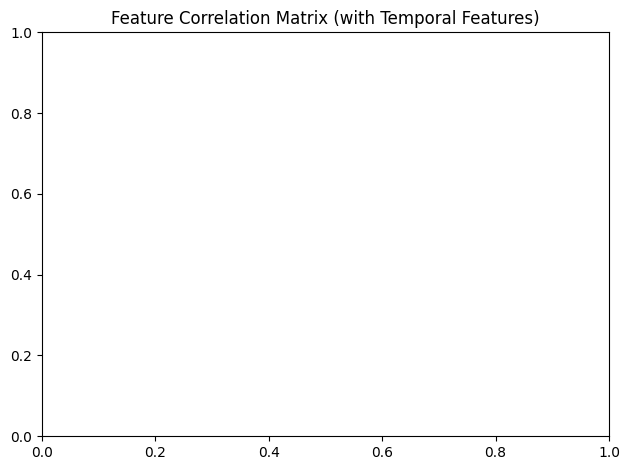


Splitting data (time-series aware)...

Training machine learning models...
🔧 Scaling features...

🚀 Training XGBoost...
[0]	validation_0-rmse:0.72755	validation_1-rmse:1.00282
[1]	validation_0-rmse:0.71370	validation_1-rmse:0.98428
[2]	validation_0-rmse:0.69846	validation_1-rmse:0.96176
[3]	validation_0-rmse:0.68372	validation_1-rmse:0.94383
[4]	validation_0-rmse:0.67106	validation_1-rmse:0.92693
[5]	validation_0-rmse:0.65711	validation_1-rmse:0.91042
[6]	validation_0-rmse:0.64460	validation_1-rmse:0.89666
[7]	validation_0-rmse:0.63041	validation_1-rmse:0.88216
[8]	validation_0-rmse:0.61765	validation_1-rmse:0.86497
[9]	validation_0-rmse:0.60480	validation_1-rmse:0.84756
[10]	validation_0-rmse:0.59319	validation_1-rmse:0.83108
[11]	validation_0-rmse:0.58139	validation_1-rmse:0.81984
[12]	validation_0-rmse:0.57058	validation_1-rmse:0.80831
[13]	validation_0-rmse:0.55822	validation_1-rmse:0.79478
[14]	validation_0-rmse:0.54852	validation_1-rmse:0.78550
[15]	validation_0-rmse:0.53907	val

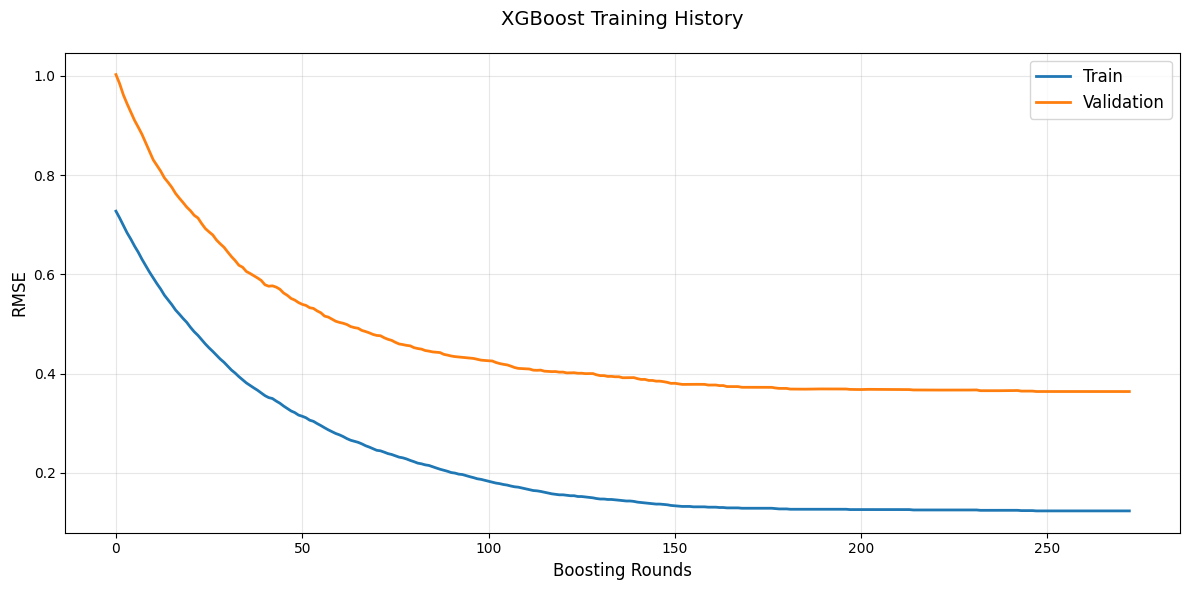

✅ XGBoost training completed in 6.11 seconds
                     XGBoost
MSE                 0.132395
RMSE                0.363862
MAE                 0.288794
R2                  0.834479
Training Time (s)   6.105008
Avg Prediction     28.606604
Std Prediction      0.608326

🚀 Training Random Forest...


<ipython-input-38-2c337eb947b5>:54: RuntimeWarning: invalid value encountered in sqrt
  train_scores_std = np.sqrt(-train_scores.std(axis=1))
<ipython-input-38-2c337eb947b5>:55: RuntimeWarning: invalid value encountered in sqrt
  test_scores_std = np.sqrt(-test_scores.std(axis=1))


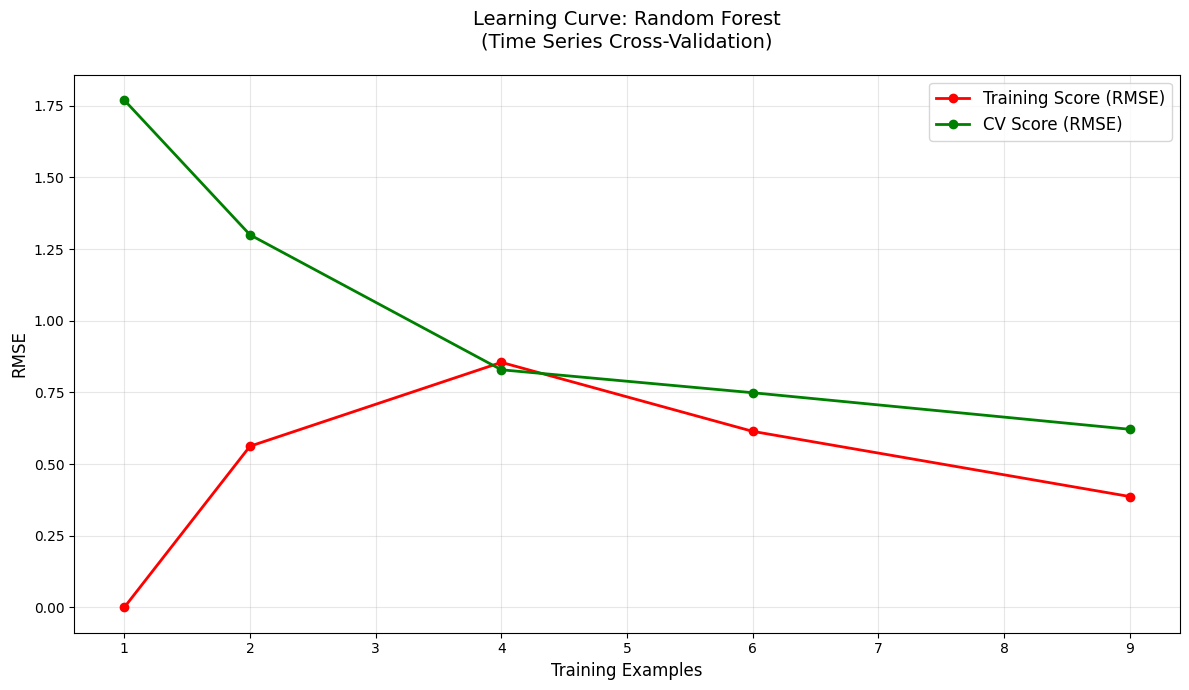

✅ Random Forest training completed in 15.18 seconds
                   Random Forest
MSE                     0.189044
RMSE                    0.434792
MAE                     0.362433
R2                      0.763657
Training Time (s)      15.177205
Avg Prediction         28.654682
Std Prediction          0.556630

🚀 Training SVR...


<ipython-input-38-2c337eb947b5>:54: RuntimeWarning: invalid value encountered in sqrt
  train_scores_std = np.sqrt(-train_scores.std(axis=1))
<ipython-input-38-2c337eb947b5>:55: RuntimeWarning: invalid value encountered in sqrt
  test_scores_std = np.sqrt(-test_scores.std(axis=1))


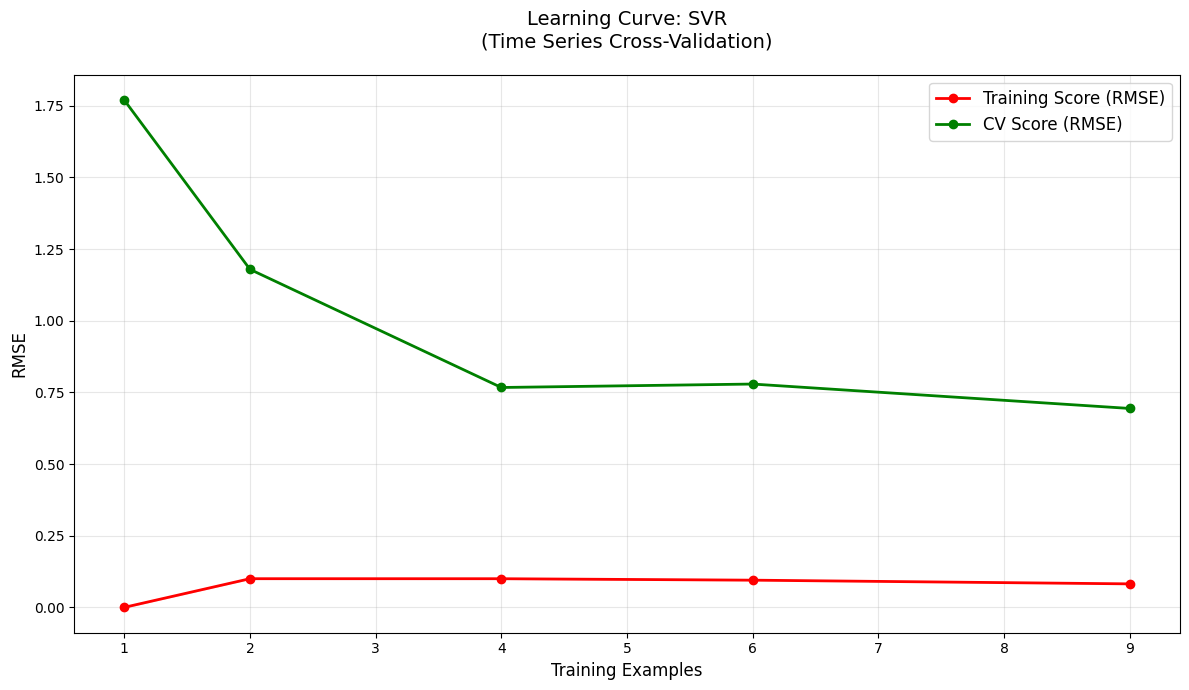

✅ SVR training completed in 0.42 seconds
                         SVR
MSE                 0.571662
RMSE                0.756083
MAE                 0.619069
R2                  0.285307
Training Time (s)   0.415851
Avg Prediction     28.574078
Std Prediction      0.213018

📊 Model Performance Summary:
                    MSE      RMSE       MAE        R2  Training Time (s)  \
XGBoost        0.132395  0.363862  0.288794  0.834479           6.105008   
Random Forest  0.189044  0.434792  0.362433  0.763657          15.177205   
SVR            0.571662  0.756083  0.619069  0.285307           0.415851   

               Avg Prediction  Std Prediction  
XGBoost             28.606604        0.608326  
Random Forest       28.654682        0.556630  
SVR                 28.574078        0.213018  

🔍 Feature Importance:


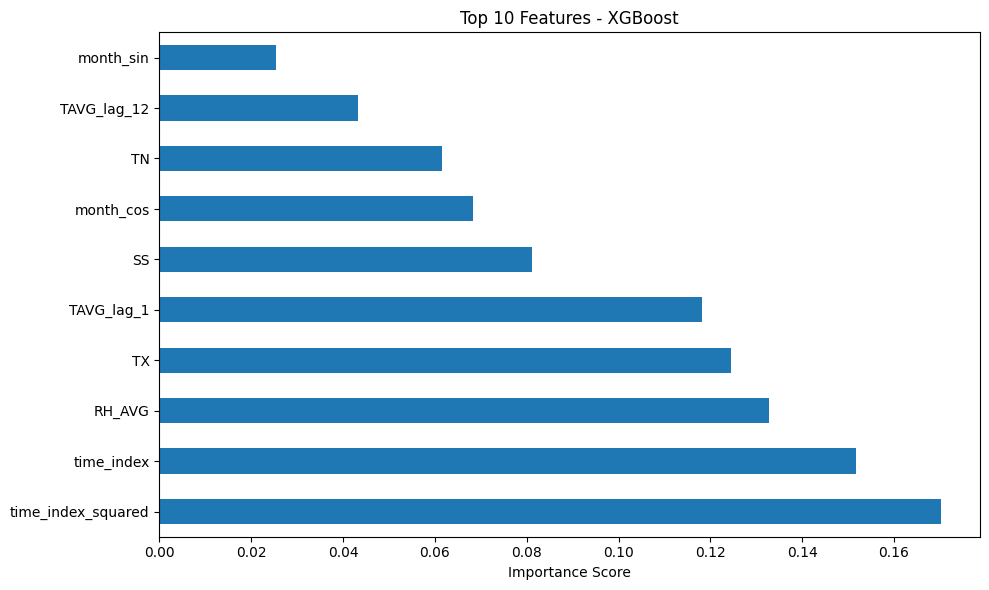

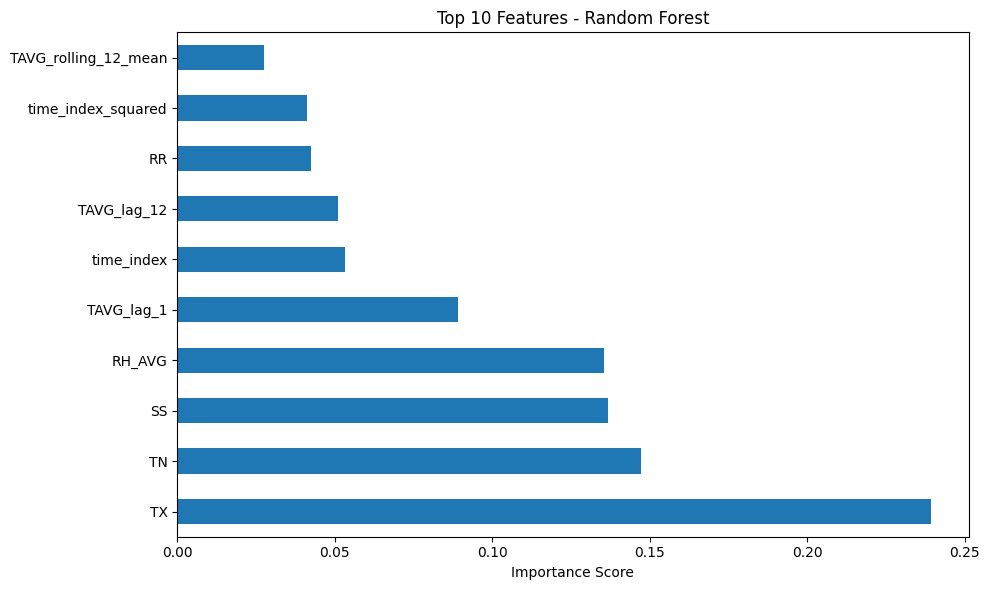

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mgsamyh/l_cbnnup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_mgsamyh/e79ibc2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45012', 'data', 'file=/tmp/tmp_mgsamyh/l_cbnnup.json', 'init=/tmp/tmp_mgsamyh/e79ibc2h.json', 'output', 'file=/tmp/tmp_mgsamyh/prophet_modeld_1ctuvf/prophet_model-20250520230554.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Model Performance Comparison:
                    MSE      RMSE       MAE        R2  Training Time (s)  \
XGBoost        0.132395  0.363862  0.288794  0.834479           6.105008   
Random Forest  0.189044  0.434792  0.362433  0.763657          15.177205   
SVR            0.571662  0.756083  0.619069  0.285307           0.415851   

               Avg Prediction  Std Prediction  
XGBoost             28.606604        0.608326  
Random Forest       28.654682        0.556630  
SVR                 28.574078        0.213018  

Running Prophet forecast...


23:05:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


An unexpected error occurred: x and y must have same first dimension, but have shapes (61,) and (49,)


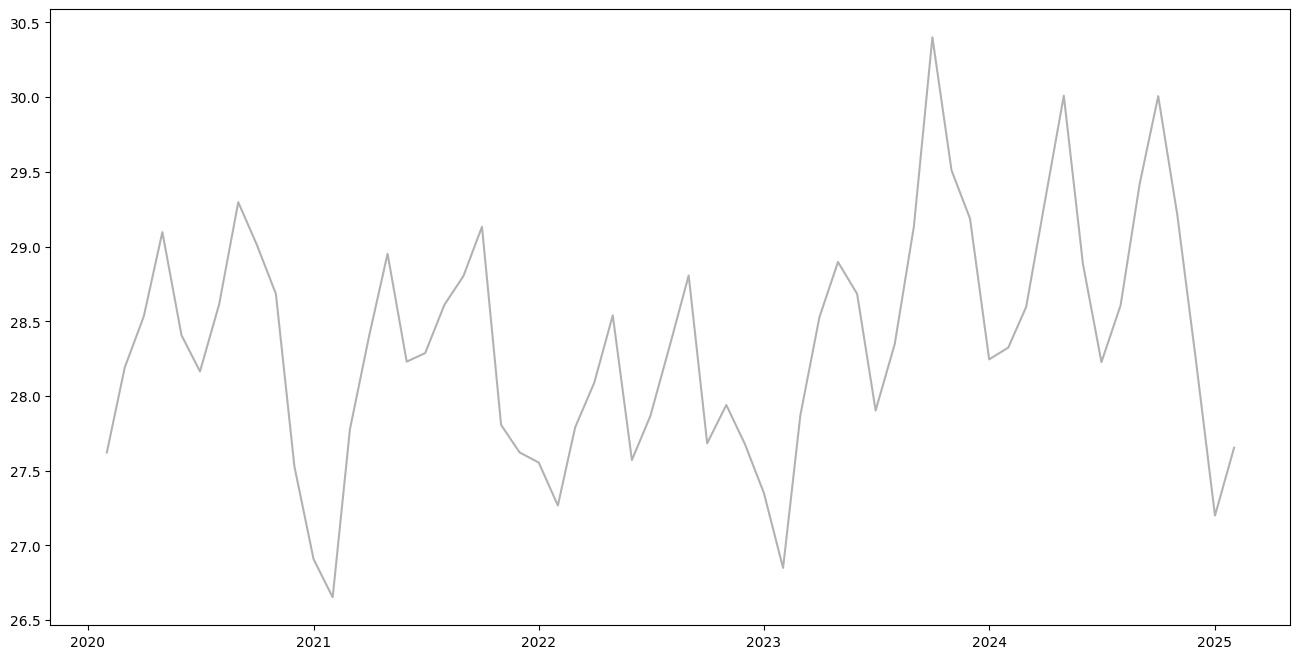

In [39]:
def main():
    try:
        # 1. Load and prepare data with error handling
        filepath = 'data.csv'  # Change to your file path
        print("Loading and preparing data...")
        monthly_df = load_and_prepare_data(filepath)

        # 2. Feature engineering with validation
        print("\nAdding temporal features...")
        feature_df = add_temporal_features(monthly_df)
        if feature_df.isnull().values.any():
            print("Warning: Missing values detected after feature engineering")
            feature_df = feature_df.dropna()

        # 3. Enhanced correlation analysis
        plt.figure(figsize=(12, 6))
        plot_correlation_matrix(feature_df)
        plt.title("Feature Correlation Matrix (with Temporal Features)")
        plt.tight_layout()
        plt.show()

        # 4. Prepare features with importance check
        X = feature_df.drop(columns=['TAVG', 'year', 'month'])
        y = feature_df['TAVG']

        # 5. Time-series aware train-test split
        print("\nSplitting data (time-series aware)...")
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        # 6. Train and evaluate models with extended metrics
        print("\nTraining machine learning models...")
        metrics, models, scaler = train_and_evaluate_models(
            X_train, X_test, y_train, y_test,
            verbose=True,
            plot_learning_curves=True
        )

        # 7. Enhanced model comparison display
        metrics_df = pd.DataFrame(metrics).T
        metrics_df = metrics_df.sort_values(by='RMSE')
        print("\nModel Performance Comparison:")
        print(metrics_df)

        # 8. Prophet forecast with confidence intervals
        print("\nRunning Prophet forecast...")
        prophet_results = run_prophet_forecast(monthly_df)

        # 9. Comprehensive visualization
        plt.figure(figsize=(16, 8))

        # Historical data
        plt.plot(monthly_df.index, monthly_df['TAVG'],
                label='Historical Data', color='gray', alpha=0.6, linewidth=1.5)

        # Machine learning model predictions (best model)
        best_model_name = metrics_df.index[0]
        best_model = models[best_model_name]
        X_all_scaled = scaler.transform(X)
        ml_predictions = best_model.predict(X_all_scaled)
        plt.plot(monthly_df.index, ml_predictions,
                label=f'{best_model_name} Predictions', linestyle='--', color='blue')

        # Prophet forecast
        plt.plot(prophet_results['ds'], prophet_results['yhat'],
                label='Prophet Forecast', linestyle='-.', color='green', linewidth=2)

        # Confidence intervals
        plt.fill_between(prophet_results['ds'],
                        prophet_results['yhat_lower'],
                        prophet_results['yhat_upper'],
                        color='green', alpha=0.1)

        # Test set period highlight
        test_period_start = monthly_df.index[split_idx]
        plt.axvline(x=test_period_start, color='red', linestyle=':',
                   label='Train/Test Split')

        plt.title('Temperature Analysis: Historical vs Forecasts', pad=20)
        plt.xlabel('Date', labelpad=10)
        plt.ylabel('Average Temperature (TAVG)', labelpad=10)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save plot
        plt.savefig('temperature_forecast_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 10. Model interpretation (feature importance)
        if hasattr(best_model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            pd.Series(best_model.feature_importances_, index=X.columns
                    ).sort_values().plot(kind='barh')
            plt.title(f'{best_model_name} Feature Importance')
            plt.tight_layout()
            plt.show()

    except FileNotFoundError:
        print(f"Error: Data file not found at {filepath}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()